In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
import typing
import tensorflow as tf
import tensorflow.keras as keras

import time

In [2]:
# declarations
RANDOM_SEED = 42
USER_FILE = '../datasets/ml-1m/users.dat'
MOVIE_FILE = '../datasets/ml-1m/movies.dat'
RATING_FILE = '../datasets/ml-1m/ratings.dat'
USER_COLS = [
    'UserID',
    'Gender',
    'Age',
    'Occupation',
    'Zipcode'
]
MOVIE_COLS = [
    'MovieID',
    'Title',
    'Genres'
]
RATING_COLS = [
    'UserID',
    'MovieID',
    'Rating',
    'Timestamp'
]

In [97]:
def read_movie_lens():
    sep = '::'
    users = pd.read_csv(USER_FILE, sep=sep, names=USER_COLS, encoding='latin-1')
    movies = pd.read_csv(MOVIE_FILE, sep=sep, names=MOVIE_COLS, encoding='latin-1')
    ratings = pd.read_csv(RATING_FILE, sep=sep, names=RATING_COLS, encoding='latin-1')
    return users, movies, ratings

users, movies, ratings = read_movie_lens()
n_users = len(users['UserID'].unique())
n_movies = len(movies['MovieID'].unique())

/Users/lap01195/Documents/dev_tools/anaconda3/envs/recsys/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [4]:
print(users.head(2))
print(movies.head(2))
print(ratings.head(2))

   UserID Gender  Age  Occupation Zipcode
0       1      F    1          10   48067
1       2      M   56          16   70072
   MovieID             Title                        Genres
0        1  Toy Story (1995)   Animation|Children's|Comedy
1        2    Jumanji (1995)  Adventure|Children's|Fantasy
   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109


## Evaluation
First, we split user ratings into training and test set based on timestamp. The ratings of each user is sorted and split according to the given ratio.

We use RMSE as the main metric for comparing algorithms on the test set.

In [5]:
def train_test_time_split(dataframe: pd.DataFrame, key_cols, ts_col, test_size=0.1) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
    train_data, test_data = [], []
    for group, data in dataframe.groupby(key_cols):
        sorted_data = data.sort_values(by=ts_col)
        if test_size * len(sorted_data) >= 1:
            split_idx = -int(np.floor(test_size * len(sorted_data)))
            train_data.append(sorted_data[:split_idx])
            test_data.append(sorted_data[split_idx:])
        else:
            train_data.append(data)
    return pd.concat(train_data), pd.concat(test_data)

In [6]:
train_ratings, test_ratings = train_test_time_split(
    ratings,
    key_cols='UserID',
    ts_col='Timestamp',
    test_size=0.1 # 10%
)

print(f'Train size: {len(train_ratings)}, Test size: {len(test_ratings)}')

Train size: 902826, Test size: 97383


## Content-based recommendation
We create a binary feature vector for each movie where non-zero entries correspond to the genres of that movie.

The predicted rating a user $u$ would give for movie $i$ is calculated as follows:
* Compute similarity of $i$ to every movie $u$ has rated
* The predicted rating for $i$ is the weighting average (by similarity) of ratings $u$ has given

In [7]:
all_genres = [
    'Action',
    'Adventure',
    'Animation',
    'Children',
    'Comedy',
    'Crime',
    'Documentary',
    'Drama',
    'Fantasy',
    'Film-Noir',
    'Horror',
    'Musical',
    'Mystery',
    'Romance',
    'Sci-Fi',
    'Thriller',
    'War',
    'Western',
    'Other'
]
movie_to_idx = {id_:i for i, id_ in enumerate(movies['MovieID'])}
user_to_idx = {id_:i for i, id_ in enumerate(users['UserID'])}
genre_to_idx = {name:i for i, name in enumerate(all_genres)}

# build the sparse feature matrix for movies
values, movie_indices, genre_indices = [], [], []
for _, row in movies.iterrows():
    for genre in row['Genres'].split('|'):
        values.append(1)
        movie_indices.append(movie_to_idx[row['MovieID']])
        if genre in genre_to_idx:
            genre_indices.append(genre_to_idx[genre])
        else:
            genre_indices.append(genre_to_idx['Other'])

movie_features = csr_matrix((values, (movie_indices, genre_indices)), shape=(len(movie_to_idx), len(genre_to_idx)))

In [8]:
# build the sparse rating matrix for users
values, user_indices, movie_indices = [], [], []
for _, row in train_ratings.iterrows():
    values.append(row['Rating'])
    user_indices.append(user_to_idx[row['UserID']])
    movie_indices.append(movie_to_idx[row['MovieID']])

user_ratings = csr_matrix((values, (user_indices, movie_indices)), shape=(len(user_to_idx), len(movie_to_idx)))

In [9]:
# compute movie similarities
movie_similarities = movie_features.dot(movie_features.T)

In [10]:
def content_based_predict_rating(users_movies: typing.List[typing.Tuple],
                                 user_ratings: csr_matrix,
                                 movie_similarities: csr_matrix,
                                 user_to_idx: dict,
                                 movie_to_idx: dict) -> typing.Tuple[list, list]:
    """
    Predict ratings for all (user_id, movie_id) pairs based on content similarity
    :param users_movies: list of (user_id, movie_id) pairs.
    :param user_ratings: sparse matrix of user ratings.
    :param movie_similarities: sparse matrix of movie-movie similarities.
    :param user_to_idx: mapping from user_id to index.
    :param movie_to_idx: mapping from movie_id to index.
    """
    def _predict_rating(movie_id, user_id):
        """
        Predict rating a user would give to a movie.
        :param movie_id: id of movie.
        :param user_id: id of user.
        :return:
        """
        user_feat = user_ratings.getrow(user_to_idx[user_id])
        user_avg = user_feat.sum() / user_feat.count_nonzero()
        sim = movie_similarities[movie_to_idx[movie_id], user_feat.nonzero()[1]]
        predicted_rating = sim.dot(user_feat.data).ravel()[0]
        total_sim = sim.sum()
        return predicted_rating / total_sim if total_sim > 0 else user_avg

    predictions = []
    for user_id, movie_id in users_movies:
        predictions.append(_predict_rating(movie_id, user_id))
    return predictions

In [11]:
users_movies_test = [(row['UserID'], row['MovieID']) for _, row in test_ratings.iterrows()]
predicted_ratings = content_based_predict_rating(users_movies_test,
                                                 user_ratings,
                                                 movie_similarities,
                                                 user_to_idx,
                                                 movie_to_idx)


In [12]:
print('RMSE (Content-based) : %.2f' % mean_squared_error(test_ratings['Rating'].values, predicted_ratings))

RMSE (Content-based) : 1.14


Content-based prediction without training makes an error about 1.14 for each movie.

## Matrix factorization
Matrix factorization is a simple method for Collaborative Filtering (CF). The term "Collaborative" emphasizes the fact that what the system recommends for a user not only based on the collected information from that user but also from other users.
### 1. SVD (Single Value Decomposition)
SVD factors the rating matrix into user and movie matrices. Let:
* $M$: the rating matrix, each row corresponds to the ratings a user has given
* $U$: the user matrix
* $V^T$: the movie matrix ($T$ stands for the transpose)
* $\Sigma$: diagonal matrix containing singular values in descending order (top-left to bottom-right)

Given $M$, SVD finds $U, V^T, \Sigma$ such that:

$$M = U \Sigma V^T$$

If we accept that many users behave similarly, $M$ can be approximated as a low rank matrix because many rows are similar or linearly dependent. By reducing the small singular values in $\Sigma$ to zeros, we are treating $M$ as low rank.

Once $\Sigma$ is reduced to $\tilde{\Sigma}$, the rating value $M_{i,j}$ is approximated as the dot product of $i$-th row of $U\sqrt{\tilde{\Sigma}}$ and $j$-th column of $\sqrt{\tilde{\Sigma}}V^T$

In [17]:
from scipy.sparse.linalg import svds

def user_movie_embedding_by_svd(utility_mat: csr_matrix, k: int = 10) -> typing.Tuple:
    """
    Use SVD to compute low-rank matrices of users and movies.
    :param utility_mat: interactions between users and movies.
    :param k: the reduced rank
    """
    U, S, VT = svds(utility_mat, k=k, which='LM', return_singular_vectors=True)
    S = np.diag(S)
    user_embeddings = np.matmul(U, np.sqrt(S))
    movie_embeddings = np.matmul(np.sqrt(S), VT)
    return user_embeddings, movie_embeddings

user_embeddings, movie_embeddings = user_movie_embedding_by_svd(user_ratings.asfptype(), k=100)


Now let's compare the observed values and the approximated values.

In [18]:
nonzero_x, nonzero_y = user_ratings.nonzero()
user_ratings_approx = np.matmul(user_embeddings, movie_embeddings)
user_ratings_approx.shape
print('M.data[:10]\n', user_ratings.data[:10])
print('Approximated M.data[:10]\n', user_ratings_approx[nonzero_x[:10], nonzero_y[:10]])

M.data[:10]
 [5 5 4 5 4 4 4 5 4 3]
Approximated M.data[:10]
 [4.18171829 2.38540566 2.84014935 5.089231   0.63147921 2.4791685
 2.11964541 3.05761372 2.54935489 1.00010352]


The actual values are often higher the approximated ones. If we increase the number of retained singular values, we can better approximate the actual ratings.

In [19]:
def CF_svd_predict_rating(users_movies: typing.List[typing.Tuple],
                          user_embeddings: np.ndarray,
                          movie_embeddings: np.ndarray,
                          user_to_idx: dict,
                          movie_to_idx: dict) -> list:
    """
    Predict ratings using SVD.
    :param users_movies: list of (user_id, movie_id) pairs.
    :param user_embeddings: factored matrix of users.
    :param movie_embeddings: factored matrix of movies.
    :param user_to_idx: mapping from user_id to index.
    :param movie_to_idx: mapping from movie_id to index.
    :return:
    """
    def _predict_rating(movie_id, user_id):
        """
        Predict rating a user would give to a movie
        :param movie_id: id of movie
        :param user_id: id of user
        :return:
        """
        user_feat = user_embeddings[user_to_idx[user_id], :]
        movie_feat = movie_embeddings[:, movie_to_idx[movie_id]]
        return np.clip(np.matmul(user_feat, movie_feat), a_min=0, a_max=5)

    predictions = []
    for user_id, movie_id in users_movies:
        predictions.append(_predict_rating(movie_id, user_id))
    return predictions

predicted_ratings = CF_svd_predict_rating(users_movies_test,
                                          user_embeddings,
                                          movie_embeddings,
                                          user_to_idx,
                                          movie_to_idx)

In [20]:
print('RMSE (CF-SVD) : %.2f' % mean_squared_error(test_ratings['Rating'].values, predicted_ratings))

RMSE (CF-SVD) : 8.71


Since the rating matrix is heavily sparse, the predicted values are pushed down by majority of zero values. That results in high prediction error.

To account for sparse ratings, we can fill empty values in the rating matrix before SVD. Two strategies to be considerered:
* Fill empty values by mean rating of each corresponding movie
* Fill empty values by mean rating of each corresponding user

In [21]:
def impute_sparse_matrix(sparse_mat: csr_matrix, by: str = 'mean_row') -> np.ndarray:
    """
    Fill the sparse matrix by mean of row or column and returns
    the dense matrix.
    :param sparse_mat: input sparse matrix.
    :param by: If by='mean_column', empty values is filled by the mean of corresponding column.
        If by='mean_row', empty values is filled by the mean of corresponding row.
    :return:
    """
    if by=='mean_column':
        reduce_axis = 0
    elif by=='mean_row':
        reduce_axis = 1
    else:
        raise ValueError('Only support mean imputation')

    dense_mat = sparse_mat.toarray()
    num_nonzero = np.sum(dense_mat > 0, axis=reduce_axis, keepdims=True)

    if not np.all(num_nonzero > 0):
        # if entire row/column is all 0, fill them by global average
        global_avg = np.sum(dense_mat) / num_nonzero.sum()
        fill_idx = (num_nonzero == 0)
        if reduce_axis == 0:
            dense_mat[:, fill_idx.ravel()] = global_avg
        if reduce_axis == 1:
            dense_mat[fill_idx.ravel(), :] = global_avg
        num_nonzero[fill_idx] = dense_mat.shape[reduce_axis]

    reduced_avg = np.sum(dense_mat, axis=reduce_axis) / num_nonzero
    avg_mat = np.repeat(reduced_avg, dense_mat.shape[reduce_axis], axis=reduce_axis)

    return np.where(dense_mat==0, avg_mat, dense_mat)

In [22]:
imputed_user_ratings = impute_sparse_matrix(user_ratings, by='mean_column')
user_embeddings, movie_embeddings = user_movie_embedding_by_svd(imputed_user_ratings, k=100)
predicted_ratings = CF_svd_predict_rating(users_movies_test,
                                          user_embeddings,
                                          movie_embeddings,
                                          user_to_idx,
                                          movie_to_idx)
print('RMSE (CF-SVD-dense) : %.2f' % mean_squared_error(test_ratings['Rating'].values, predicted_ratings))

RMSE (CF-SVD-dense) : 0.91


By filling empty values by the average ratings of corresponding items, we can greatly reduce the RMSE.

SVD is a powerful method for CF, yet it becomes computationally expensive when the rating matrix gets bigger. Moreover, it requires to choose an imputation strategy for unobserved ratings.

### Funk SVD (or Regularized SVD)
Funk SVD doesn't perform SVD, but it shares the same target with SVD by finding user and movie embeddings that best construct the observed rating. Besides, Funk SVD also finds user bias and movie bias. Intuitively:
* *User bias* accounts for how picky a user on average.
* *Movie bias* accounts for how good a movie on average.

Let:
* $K$: the set of indices of observed ratings.
* $(u, i)$: user and movie index.
* $BU$: user bias.
* $BI$: movie bias.
* $M$: the rating matrix.
* $(P,Q)$: user and movie embedding matrix.
* $\mu$: global average rating

$P,Q,BU,BI$ can be effectively obtained by using Gradient Descend to solve:

$$\text{min}_{P,Q,BU,BI} \sum_{(u,i) \in K} (M_{u,i} - \mu - BU_u - BI_i - P_u^TQ_i)$$

In [69]:
class CustomBias(keras.layers.Layer):
    """Bias layer that adds bias into the inputs"""
    def __init__(self, name='custom_bias'):
        super(CustomBias, self).__init__(name=name)

    def build(self, input_shape):
        b_init = tf.zeros_initializer()
        self.b = self.add_weight(
            shape=(input_shape[-1],), initializer=b_init, trainable=True
        )

    def call(self, inputs):
        return inputs + self.b


class Funk_SVD(keras.Model):
    """Keras model definition of Funk SVD"""
    def __init__(self, num_users, num_movies, embedding_dim=50, weight_decay=1e-5):
        super(Funk_SVD, self).__init__()

        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_dim = embedding_dim
        self.user_embeddings = keras.layers.Embedding(self.num_users,
                                                      self.embedding_dim,
                                                      input_length=1,
                                                      embeddings_regularizer=keras.regularizers.l2(weight_decay),
                                                      name='user_embeddings')
        self.movie_embeddings = keras.layers.Embedding(self.num_movies,
                                                       self.embedding_dim,
                                                       input_length=1,
                                                       embeddings_regularizer=keras.regularizers.l2(weight_decay),
                                                       name='movie_embeddings')
        self.user_biases = keras.layers.Embedding(self.num_users, 1, input_length=1,
                                                  name='user_biases')
        self.movie_biases = keras.layers.Embedding(self.num_movies, 1, input_length=1,
                                                   name='movie_biases')
        self.global_bias = CustomBias(name='global_bias')
        self.flatten = keras.layers.Flatten()

    @tf.function
    def call(self, inputs):
        user_index, movie_index = inputs[0], inputs[1]
        output = tf.math.reduce_sum(self.user_embeddings(user_index) * self.movie_embeddings(movie_index)) + \
                 self.flatten(self.user_biases(user_index) + self.movie_biases(movie_index))
        output = self.global_bias(output)
        output = tf.clip_by_value(output, -2, 2)
        return output

    def get_user_embeddings(self):
        """Return user embeddings"""
        return self.user_embeddings.get_weights()

    def get_movie_embeddings(self):
        """Return movie embeddings"""
        return self.movie_embeddings.get_weights()

In [92]:
def train_validation_dataset(train_ratings: pd.DataFrame, user_to_idx: dict, movie_to_idx: dict, batch_size=128) -> typing.Tuple[tf.data.Dataset, tf.data.Dataset]:
    """
    Create training and validation in TF Dataset format.
    :param train_ratings: the ratings data for training.
    :param user_to_idx: mapping from user_id to index.
    :param movie_to_idx: mapping from movie_id to index.
    :param batch_size: training batch size
    """
    train_ratings, val_ratings = train_test_time_split(
        train_ratings,
        key_cols='UserID',
        ts_col='Timestamp',
        test_size=0.05 # 5%
    )

    def create_input_output_ds(df):
        x1 = df['UserID'].apply(lambda x: user_to_idx[x]).values
        x2 = df['MovieID'].apply(lambda x: movie_to_idx[x]).values
        y = (df['Rating'] - 3).values
        return (tf.data.Dataset.from_tensor_slices((x1, x2)),
               tf.data.Dataset.from_tensor_slices(y))

    train_input, train_output = create_input_output_ds(train_ratings)
    val_input, val_output = create_input_output_ds(val_ratings)

    train_ds = (tf.data.Dataset.zip((train_input, train_output))
                .shuffle(10000)
                .batch(batch_size))
    val_ds = (tf.data.Dataset.zip((val_input, val_output))
              .batch(batch_size))
    return train_ds, val_ds


train_ds, val_ds = train_validation_dataset(train_ratings, user_to_idx, movie_to_idx, batch_size=256)

In [93]:
keras.backend.clear_session()
funk_svd = Funk_SVD(n_users,
                    n_movies,
                    embedding_dim=30,
                    weight_decay=0.00001)
funk_svd.build(input_shape=[(1,), (1,)])
funk_svd.summary()
funk_svd.compile(optimizer=keras.optimizers.SGD(learning_rate=0.05),
                 loss='mse',
                 metrics=[keras.metrics.RootMeanSquaredError()])
history = funk_svd.fit(x=train_ds, validation_data=val_ds, epochs=100)


Model: "funk_svd"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
user_embeddings (Embedding)  multiple                  181200    
_________________________________________________________________
movie_embeddings (Embedding) multiple                  116490    
_________________________________________________________________
user_biases (Embedding)      multiple                  6040      
_________________________________________________________________
movie_biases (Embedding)     multiple                  3883      
_________________________________________________________________
global_bias (CustomBias)     multiple                  1         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
Total params: 307,614
Trainable params: 307,614
Non-trainable params: 0
____________________________________________________

/Users/lap01195/Documents/dev_tools/anaconda3/envs/recsys/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


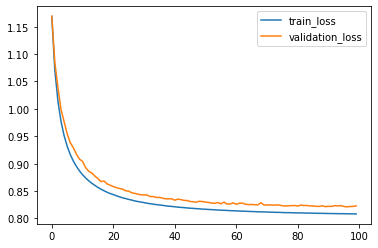

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()

In [95]:
def CF_funk_svd_predict_rating(users_movies: typing.List[typing.Tuple], model, user_to_idx, movie_to_idx) -> np.ndarray:
    """
    Predict ratings using Funk SVD.
    :param users_movies: list of user and movie id.
    :param model: trained Funk-SVD model.
    :param user_to_idx: mapping from user_id to index.
    :param movie_to_idx: mapping from movie_id to index.
    :return:
    """
    inputs = list(zip(*users_movies))
    user_index = list(map(lambda x: user_to_idx[x], inputs[0]))
    movie_index = list(map(lambda x: movie_to_idx[x], inputs[1]))
    return model.predict((np.array(user_index, dtype=np.int32).reshape(-1,1),
                          np.array(movie_index, dtype=np.int32).reshape(-1,1))).ravel() + 3

users_movies_test = [(row['UserID'], row['MovieID']) for _, row in test_ratings.iterrows()]
predicted_ratings = CF_funk_svd_predict_rating(users_movies_test, funk_svd, user_to_idx, movie_to_idx)

In [96]:
print('RMSE (CF-Funk-SVD) : %.2f' % mean_squared_error(test_ratings['Rating'].values, predicted_ratings))


RMSE (CF-Funk-SVD) : 0.86


Funk-SVD has improved SVD performed on imputed rating matrix.

END.
